In [4]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [5]:
mb_keys_dict = {
    'crop': np.array([18,19,39,20,40,62,41,36,46,47,35,48]),
    'forest': np.array([3]),
    'pasture': np.array([15])
}

In [6]:
def read_process_lulc_csv(csv):
    df = pd.read_csv(csv, index_col=0)
    df = df.loc[:, df.columns[-1]]
#     lulc_y = int(df.name[31:35]) # For interview area only
    lulc_y = int(df.name[42:46]) # For all of mato grosso

    df = pd.DataFrame(list(df.apply(eval).values), index=df.index)
    df.columns = pd.MultiIndex.from_product([[lulc_y], df.columns])
    return df

def summarize_lulc(year_df):
    out_df = pd.DataFrame()
    for lulc_class in mb_keys_dict.keys():
        sum_of_class = year_df.loc[:, np.in1d(year_df.columns, mb_keys_dict[lulc_class])].sum(axis=1)
        out_df[lulc_class] = sum_of_class
    return out_df

def classify_lulc(lulc_counts_df):
    # NOTE: Originally did not have forest check in this, probably need to redo the calculations
    is_forest = (lulc_counts_df['crop'] < 100) & (lulc_counts_df['pasture'] < 100) & (lulc_counts_df['forest'] > 100)
    is_crop = lulc_counts_df['crop'] > lulc_counts_df['pasture']
    is_pasture = lulc_counts_df['crop'] < lulc_counts_df['pasture']
    lulc_counts_df['class'] = 'other'
    lulc_counts_df.loc[is_crop, 'class'] = 'crop'
    lulc_counts_df.loc[is_pasture, 'class'] = 'pasture'
    lulc_counts_df.loc[is_forest, 'class'] = 'forest'
    
    return lulc_counts_df['class']

def calc_lulc_full(df):
#     new_df = pd.DataFrame(df.index).set_index('id') # For interview area only
    new_df = pd.DataFrame(df.index).set_index('id_in_tile')

    for y in df.columns.levels[0]:
        year_df = summarize_lulc(df[y])
        year_df.index = df.index
        classes = classify_lulc(year_df)
        new_df.loc[:, y] = classes
        
    return new_df


def past_transitions(lulc_df, is_current_lulc, y):
    
    # Past transitions
    # Find index most recent non current lulc going backwards
    transition_idx_past = np.argmax(np.cumsum(~is_current_lulc.loc[:, :y].values, axis=1), axis=1)
       
    trans_df = pd.DataFrame(index=lulc_df.index)
    trans_df['transition_year_past'] = lulc_df.columns[transition_idx_past]
    trans_df['last_transition_past'] = (lulc_df.values[np.arange(lulc_df.shape[0]), transition_idx_past]
                                       + '-' + lulc_df[y])
    trans_df['years_since_transition'] = (y - trans_df['transition_year_past'])
    trans_df['res_count'] = 1

    past_transition_count = trans_df[
    ['last_transition_past','years_since_transition','res_count']
       ].groupby(['last_transition_past','years_since_transition']).count()
    # Drop non transitions
    past_transition_count = past_transition_count.drop(
            ['crop-crop', 'forest-forest','pasture-pasture'], errors='ignore'
        )
    
    return past_transition_count
    

def future_transitions(lulc_df, is_current_lulc, y):
    # Find index first non current lulc going forward
    # Need to add index of current year since slices is_current_lulc from y onwards
    transition_idx_future = (np.argmax(~is_current_lulc.loc[:, (y+1):].values, axis=1)
                             + (y - 1985))


    trans_df = pd.DataFrame(index=lulc_df.index)
    trans_df['transition_year_future'] = lulc_df.columns[transition_idx_future]
    trans_df['next_transition_future'] = (lulc_df[y] + '-'
                                         + lulc_df.values[np.arange(lulc_df.shape[0]), transition_idx_future+1])
    trans_df['years_to_transition'] = (y - trans_df['transition_year_future'])
    trans_df['res_count'] = 1
    future_transition_count = trans_df[
    ['next_transition_future','years_to_transition','res_count']
       ].groupby(['next_transition_future','years_to_transition']).count()
    # Drop non transitions
    future_transition_count = future_transition_count.drop(
            ['crop-crop', 'forest-forest','pasture-pasture'], errors='ignore'
        )
    # Clean up column names
    
    return future_transition_count


def cur_year_transitions_past_years(lulc_df, cur_year_is_transition, y):
    min_year = lulc_df.columns.min()
    transition_type = lulc_df.loc[cur_year_is_transition, y] + '-' + lulc_df.loc[cur_year_is_transition, y+1]
    is_pre_transition_lulc = lulc_df[list(np.arange(min_year, y+1))].loc[
        cur_year_is_transition].eq(
        lulc_df.loc[cur_year_is_transition, y], axis=0)
    years_before_transition = np.argmax(np.cumsum(~is_pre_transition_lulc.loc[:, :y].values, axis=1), axis=1)
    years_before_transition -= (y - min_year)
    
    trans_df = pd.DataFrame(index=lulc_df.loc[cur_year_is_transition].index)
    trans_df['years_pre_trans_as_class'] = years_before_transition
    trans_df['cur_transition'] = transition_type
    trans_df['res_count'] = 1
    
    cur_transition_past_years_count = trans_df[
    ['cur_transition','years_pre_trans_as_class','res_count']
       ].groupby(['cur_transition','years_pre_trans_as_class']).count()
    
    # Values need to be cumulative
    cumulative_dfs = []
    for trans_type in cur_transition_past_years_count.index.levels[0]:
        new_df = pd.DataFrame({'year':np.arange(min_year - y, 1)})
        new_df.index = new_df['year']
        new_df['transition_type'] = trans_type
        cur_trans_df = cur_transition_past_years_count.loc[trans_type]
        res_count_for_cumsum = pd.concat([new_df, cur_trans_df], axis=1).sort_index(ascending=True)['res_count'].fillna(0).values
        new_df = new_df.sort_index(ascending=True)
        new_df['res_count'] = np.cumsum(res_count_for_cumsum)
        cumulative_dfs.append(new_df)
    cur_past_count_cumul = pd.concat(cumulative_dfs, axis=0).set_index(['transition_type','year'])
    
    return cur_past_count_cumul
    
def cur_year_transitions_future_years(lulc_df, cur_year_is_transition,y):
    max_year = lulc_df.columns.max()
    transition_type = lulc_df.loc[cur_year_is_transition, y] + '-' + lulc_df.loc[cur_year_is_transition, y+1]
    is_post_transition_lulc = lulc_df[list(np.arange(y+1, max_year+1))].loc[
        cur_year_is_transition].eq(
        lulc_df.loc[cur_year_is_transition, y+1], axis=0)
    years_remain_transition = (np.argmax(~is_post_transition_lulc.loc[:, (y+1):].values, axis=1))
    years_remain_transition[years_remain_transition==0] = (max_year - (y+1))
    
    trans_df = pd.DataFrame(index=lulc_df.loc[cur_year_is_transition].index)
    trans_df['years_post_trans_as_class'] = years_remain_transition
    trans_df['cur_transition'] = transition_type
    trans_df['res_count'] = 1
    
    cur_transition_future_years_count = trans_df[
    ['cur_transition','years_post_trans_as_class','res_count']
       ].groupby(['cur_transition','years_post_trans_as_class']).count()
    
    # Values need to be cumulative
    cumulative_dfs = []
    for trans_type in cur_transition_future_years_count.index.levels[0]:
        new_df = pd.DataFrame({'year':np.arange(0, (max_year - (y)))})
        new_df.index = new_df['year']
        new_df['transition_type'] = trans_type
        cur_trans_df = cur_transition_future_years_count.loc[trans_type]
        res_count_for_cumsum = pd.concat([new_df, cur_trans_df], axis=1).sort_index(ascending=False)['res_count'].fillna(0).values
        new_df = new_df.sort_index(ascending=False)
        new_df['res_count'] = np.cumsum(res_count_for_cumsum)
        new_df = new_df.loc[new_df['year']>0]
        cumulative_dfs.append(new_df)
    cur_future_count_cumul = pd.concat(cumulative_dfs, axis=0).set_index(['transition_type','year'])
    
    return cur_future_count_cumul

def process_year_lulc(y):
    all_csvs = glob.glob('./out/lulc_stats_res_{}_mb_*_counts.csv'.format(y))
    all_csvs.sort()
    full_df = pd.concat([read_process_lulc_csv(csv) for csv in all_csvs], axis=1)
    lulc_df = calc_lulc_full(full_df)
    is_current_lulc = lulc_df.eq(lulc_df[y], axis=0)
    cur_year_is_transition = lulc_df[y] != lulc_df[y+1]
    
    # Looking ahead to next transition
    future_transition_count = future_transitions(lulc_df, is_current_lulc, y)
    
    # Looking back to most recent transition
    past_transition_count = past_transitions(lulc_df, is_current_lulc, y)
    
    # If current year transition, how long did it remain into the future
    cur_transition_count_future = cur_year_transitions_future_years(lulc_df, cur_year_is_transition, y)
    
    # If current year_transition, how long ago did it transition last
    cur_transition_count_past = cur_year_transitions_past_years(lulc_df, cur_year_is_transition, y)
    
    
    proximal_transition_df = pd.concat([future_transition_count, past_transition_count])
    cur_transition_df = pd.concat([cur_transition_count_past, cur_transition_count_future])
    return proximal_transition_df, cur_transition_df
#     return lulc_df

In [4]:
year_range = np.arange(1985, 2022)
# year_range = year_range[year_range!=2019]

# Transitions centered at 0

In [5]:
all_proximal_cur_dfs = [process_year_lulc(y) for y in np.arange(1985, 2022)]

In [6]:
all_prox_dfs = [t[0] for t in all_proximal_cur_dfs]
all_cur_dfs = [t[1] for t in all_proximal_cur_dfs]

In [17]:
full_prox_df = pd.concat(all_prox_dfs).groupby(level=[0,1]).mean()['res_count'] #pd.concat(all_prox_dfs, axis=1).mean(axis=1)
full_prox_df.name = 'res_count_prox'
full_cur_df = pd.concat(all_cur_dfs, axis=1).mean(axis=1)
full_cur_df.name = 'res_count_cur'
full_all_df = pd.concat([full_cur_df, full_prox_df], axis=1).fillna(1).replace(0,1)

In [93]:
full_prox_df['forest-pasture'].max()

1351.25

In [94]:
full_prox_df['pasture-crop'].max()

336.8484848484849

In [38]:
full_prox_df.to_csv('full_prox_df.csv')

In [39]:
full_cur_df.to_csv('full_cur_df.csv')

# v1: "Normalize" by # of reservoirs the year of transition

In [66]:
diff_df = full_all_df['res_count_prox'] - full_all_df['res_count_cur']

In [67]:
ratio_df = full_all_df['res_count_prox'] / full_all_df['res_count_cur']

<Axes: >

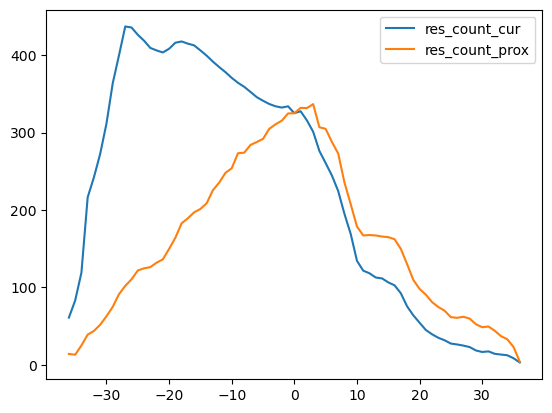

In [68]:
full_all_df.loc['pasture-crop'].sort_index().plot()

<Axes: >

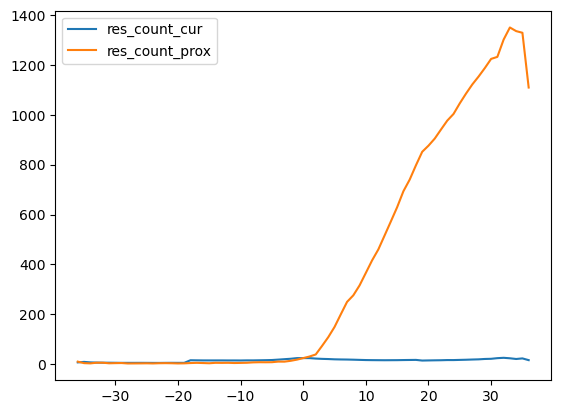

In [69]:
full_all_df.loc['forest-pasture'].sort_index().plot()

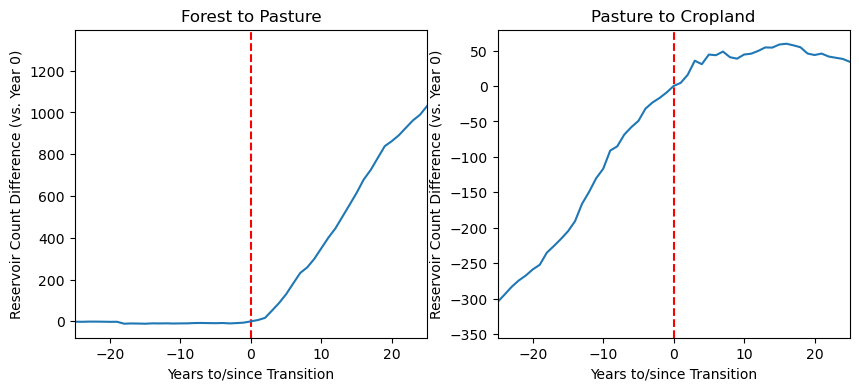

In [70]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].axvline(0, color='red', linestyle='--')
axs[1].axvline(0, color='red', linestyle='--')
diff_df.loc['forest-pasture'].sort_index().plot(ax=axs[0])
diff_df.loc['pasture-crop'].sort_index().plot(ax=axs[1])
axs[0].set_xlabel('Years to/since Transition')
axs[1].set_xlabel('Years to/since Transition')
axs[0].set_ylabel('Reservoir Count Difference (vs. Year 0)')
axs[1].set_ylabel('Reservoir Count Difference (vs. Year 0)')
axs[0].set_title('Forest to Pasture')
axs[1].set_title('Pasture to Cropland')
axs[0].set_xlim(-25, 25)
axs[1].set_xlim(-25, 25)
plt.show()

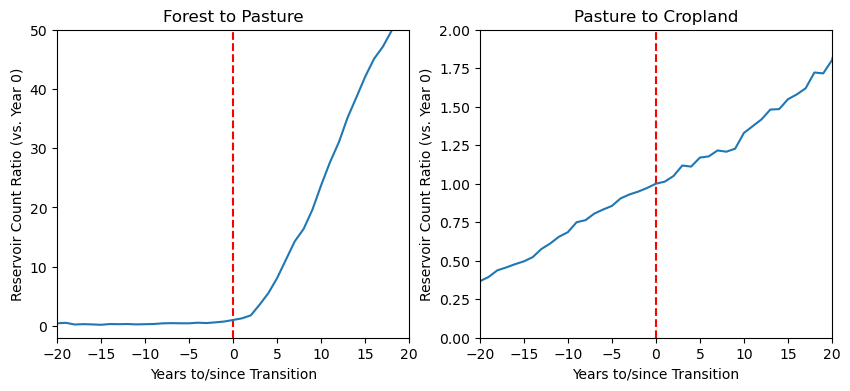

In [73]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].axvline(0, color='red', linestyle='--')
axs[1].axvline(0, color='red', linestyle='--')
ratio_df.loc['forest-pasture'].sort_index().plot(ax=axs[0])
ratio_df.loc['pasture-crop'].sort_index().plot(ax=axs[1])
axs[0].set_xlabel('Years to/since Transition')
axs[1].set_xlabel('Years to/since Transition')
axs[0].set_ylabel('Reservoir Count Ratio (vs. Year 0)')
axs[1].set_ylabel('Reservoir Count Ratio (vs. Year 0)')
axs[0].set_title('Forest to Pasture')
axs[1].set_title('Pasture to Cropland')
axs[0].set_xlim(-20, 20)
axs[1].set_xlim(-20, 20)
axs[0].set_ylim(-2, 50)
axs[1].set_ylim(0, 2)

plt.show()

In [8]:
# full_transition_df = pd.concat(all_transition_dfs, axis=1).mean(axis=1)

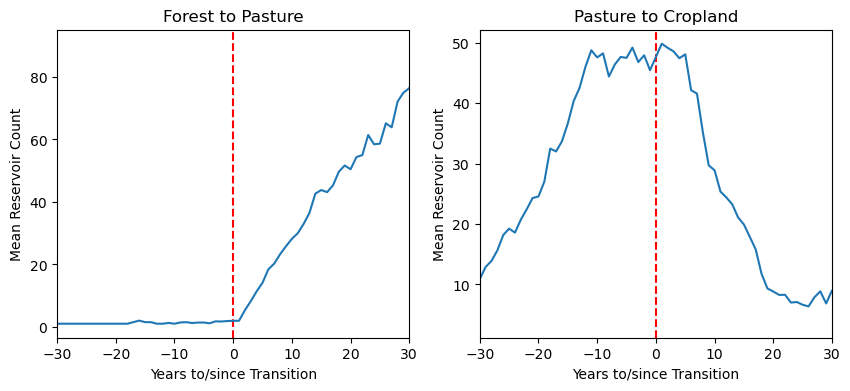

In [17]:
# fig, axs = plt.subplots(1,2, figsize=(10,4))
# axs[0].axvline(0, color='red', linestyle='--')
# axs[1].axvline(0, color='red', linestyle='--')
# full_transition_df.loc['forest-pasture'].sort_index().plot(ax=axs[0])
# full_transition_df.loc['pasture-crop'].sort_index().plot(ax=axs[1])
# axs[0].set_xlabel('Years to/since Transition')
# axs[1].set_xlabel('Years to/since Transition')
# axs[0].set_ylabel('Mean Reservoir Count')
# axs[1].set_ylabel('Mean Reservoir Count')
# axs[0].set_title('Forest to Pasture')
# axs[1].set_title('Pasture to Cropland')
# axs[0].set_xlim(-30, 30)
# axs[1].set_xlim(-30, 30)
# plt.show()

# v2: Normalize by land area of each type

In [64]:
fp_lulc_df = pd.read_csv('./lulc_transitions_relative_fp.csv').set_index('year').mean(axis=1)
pc_lulc_df = pd.read_csv('./lulc_transitions_relative_pc.csv').set_index('year').mean(axis=1)

### Forest-pasture

<Axes: xlabel='years_to_transition'>

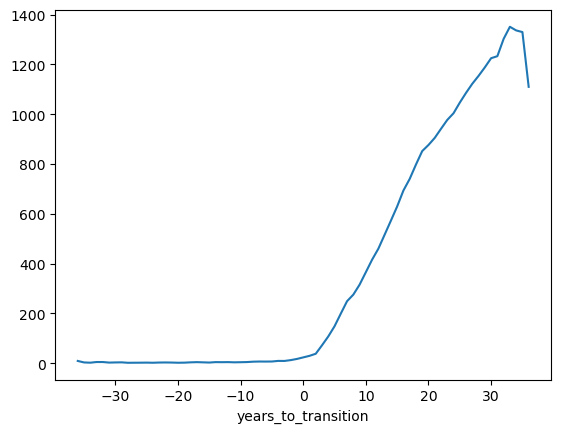

In [65]:
full_prox_df.loc['forest-pasture'].plot()

<Axes: xlabel='year'>

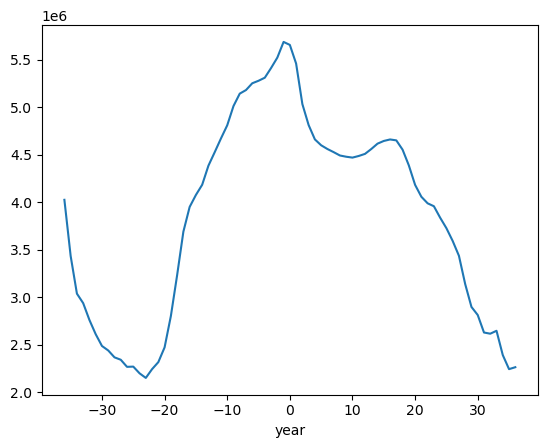

In [66]:
fp_lulc_df.plot()

In [67]:
fp_density_df = full_prox_df['forest-pasture']/fp_lulc_df

<Axes: xlabel='years_to_transition'>

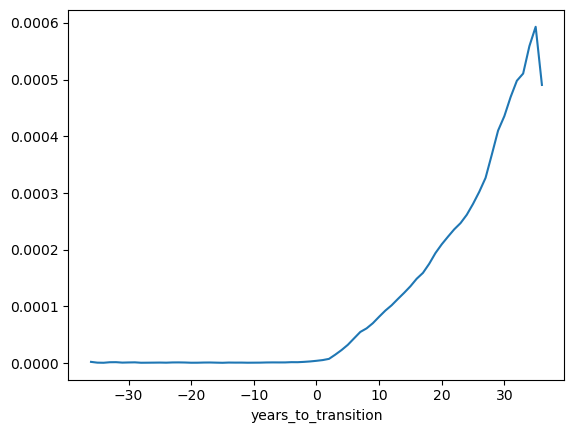

In [68]:
fp_density_df.plot()

### Pasture-crop

<Axes: xlabel='years_to_transition'>

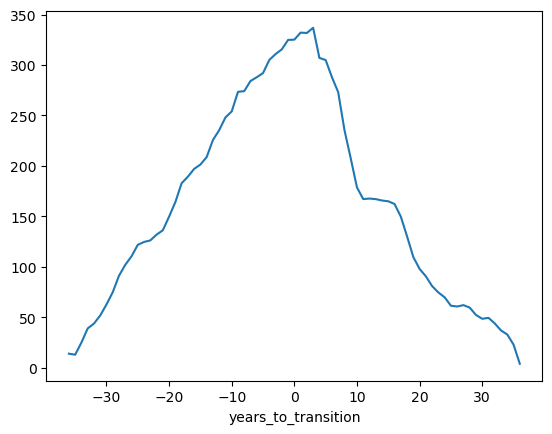

In [69]:
full_prox_df.loc['pasture-crop'].plot()

<Axes: xlabel='year'>

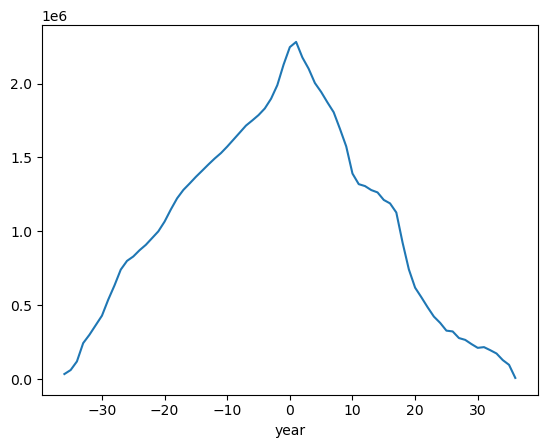

In [70]:
pc_lulc_df.plot()

In [71]:
pc_density_df = full_prox_df['pasture-crop']/pc_lulc_df

<Axes: xlabel='years_to_transition'>

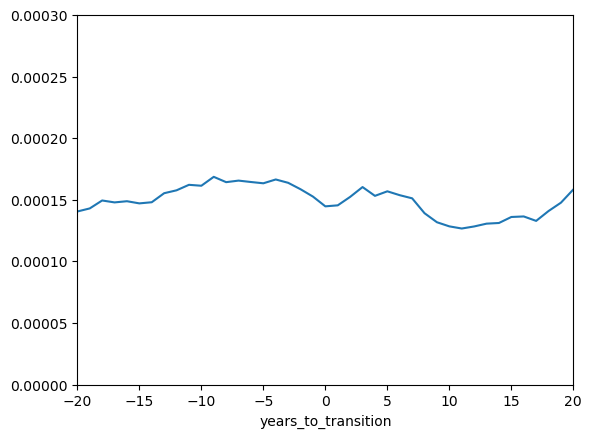

In [79]:
pc_density_df.plot(xlim=[-20, 20],ylim=[0, 0.0003])

In [ ]:
pc_density_df.plot(xlim=[-20, 20])

## Together

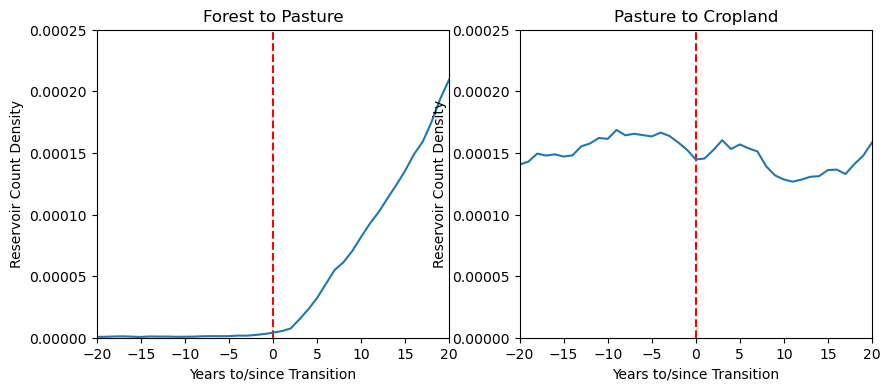

In [89]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
axs[0].axvline(0, color='red', linestyle='--')
axs[1].axvline(0, color='red', linestyle='--')
fp_density_df.plot(ax=axs[0])
pc_density_df.plot(ax=axs[1])

axs[0].set_xlabel('Years to/since Transition')
axs[1].set_xlabel('Years to/since Transition')
axs[0].set_ylabel('Reservoir Count Density')
axs[1].set_ylabel('Reservoir Count Density')
axs[0].set_title('Forest to Pasture')
axs[1].set_title('Pasture to Cropland')
axs[0].set_xlim(-20, 20)
axs[1].set_xlim(-20, 20)
axs[0].set_ylim(0,0.00025)
axs[1].set_ylim(0,0.00025)
plt.show()

# Plot number of reservoirs in each lulc class over the years and total LULC area

In [98]:
def read_process_lulc_csv(csv):
    df = pd.read_csv(csv, index_col=0)
    df = df.loc[:, df.columns[-1]]
#     df = df.rename(int(df.name[31:35]))
    df = df.rename(int(df.name[42:46]))
    return df.apply(eval)

def summarize_lulc(lulc_dict):
    out_dict = {}
    for lulc_class in mb_keys_dict.keys():
        idx_of_class = np.in1d(list(lulc_dict.keys()), mb_keys_dict[lulc_class])
        sum_of_class = np.sum(np.array(list(lulc_dict.values()))[idx_of_class])
        out_dict[lulc_class] = sum_of_class
    return out_dict

def classify_lulc(lulc_dict_df):
    is_forest = (lulc_dict_df['crop'] < 100) & (lulc_dict_df['pasture'] < 100)
    is_crop = lulc_dict_df['crop'] > lulc_dict_df['pasture']
    is_pasture = lulc_dict_df['crop'] < lulc_dict_df['pasture']
    lulc_dict_df['class'] = 'other'
    lulc_dict_df.loc[is_crop, 'class'] = 'crop'
    lulc_dict_df.loc[is_pasture, 'class'] = 'pasture'
    lulc_dict_df.loc[is_forest, 'class'] = 'forest'
    
    return lulc_dict_df['class']

def calc_lulc_full(df):
    new_df = pd.DataFrame(df.index).set_index('id_in_tile')
    for y in df.columns:
        year_df = pd.DataFrame.from_dict(list(df[y].apply(summarize_lulc).values))
        year_df.index = df.index
        classes = classify_lulc(year_df)
        new_df.loc[:, y] = classes
        
    return new_df

def process_year_lulc_ofyearonly(y):
    all_csvs = glob.glob('./out/lulc_stats_res_{}_mb_{}_counts.csv'.format(y, y))
    all_csvs.sort()
    full_df = pd.concat([read_process_lulc_csv(csv) for csv in all_csvs], axis=1)
    lulc_df = calc_lulc_full(full_df)
    lulc_df = lulc_df.rename(columns={y:'class'})
    lulc_df[y] = 1
    
    return lulc_df


In [99]:
all_yearof_df = [process_year_lulc_ofyearonly(y) for y in year_range]
yearof_counts_df = [df.groupby('class').count() for df in all_yearof_df]
full_yearof_df = pd.concat(yearof_counts_df, axis=1)

<Axes: >

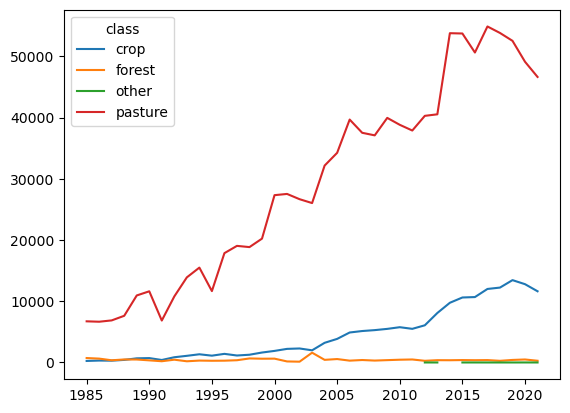

In [100]:
full_yearof_df.T.plot()

# LULC fig

In [101]:
annual_lulc = pd.read_csv('./csvs/lulc_summary_mt.csv').set_index('year')
annual_lulc*= (100/10000)
annual_lulc['Total Agricultural'] = annual_lulc['pasture'] +  annual_lulc['crop']
annual_lulc.rename(columns={'pasture': 'Pasture', 'crop': 'Crop'}, inplace=True)

<Axes: title={'center': 'Ag Area'}, xlabel='year', ylabel='Area (ha)'>

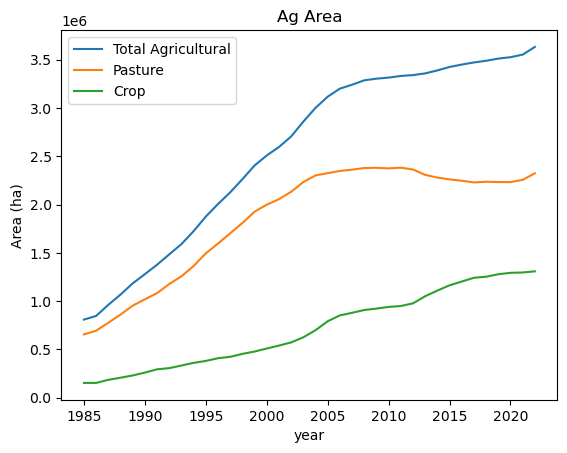

In [103]:
annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ylabel='Area (ha)', title='Ag Area')

In [112]:
annual_res_lulc = full_yearof_df.T

In [113]:
annual_res_lulc = annual_res_lulc#.drop(columns=['other', 'forest'])
annual_res_lulc = annual_res_lulc.rename(columns={'crop': 'Crop','pasture':'Pasture'})
annual_res_lulc['Total Agricultural'] = annual_res_lulc['Crop'] + annual_res_lulc['Pasture']
annual_res_lulc.columns.name = None

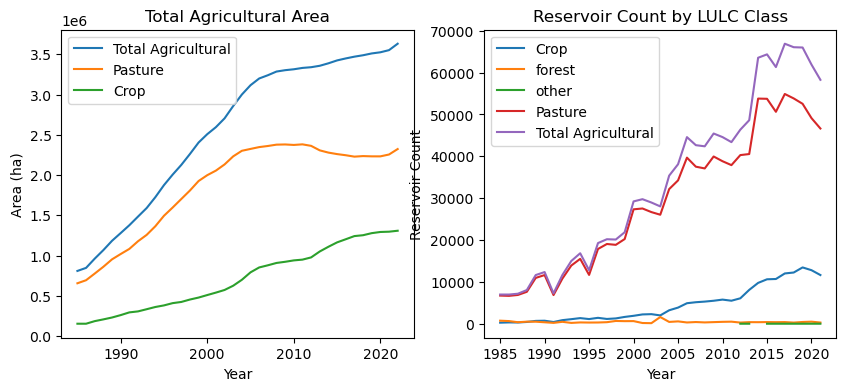

In [118]:
# Together
fig, axs = plt.subplots(1,2, figsize=(10,4))
# annual_res_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[1])
annual_res_lulc.plot(ax=axs[1])
annual_lulc[['Total Agricultural', 'Pasture', 'Crop']].plot(ax=axs[0])
axs[0].set_xlabel('Year')
axs[1].set_xlabel('Year')
axs[0].set_ylabel('Area (ha)')
axs[1].set_ylabel('Reservoir Count')
axs[0].set_title('Total Agricultural Area')
axs[1].set_title('Reservoir Count by LULC Class')
plt.show()

# Plot trajectory for single transition year

In [172]:
single_year_prox_df = all_prox_dfs[18]

In [129]:
full_fp_df = pd.read_csv('./lulc_transitions_forward_fp.csv',index_col=0).fillna(
    pd.read_csv('./lulc_transitions_backward_fp.csv',index_col=0))
full_pc_df = pd.read_csv('./lulc_transitions_forward_pc.csv',index_col=0).fillna(
    pd.read_csv('./lulc_transitions_backward_pc.csv',index_col=0))


In [179]:
single_year_fp_df = full_fp_df['2005']
single_year_fp_df.loc[2005] = single_year_fp_df.loc[2006]

/tmp/ipykernel_41667/3220407400.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_year_fp_df.loc[2005] = single_year_fp_df.loc[2006]


In [180]:
single_year_pc_df = full_pc_df['2005']
single_year_pc_df.loc[2005] = single_year_pc_df.loc[2006]

/tmp/ipykernel_41667/1771936278.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_year_pc_df.loc[2005] = single_year_pc_df.loc[2006]


In [173]:
pc_singleyear = single_year_prox_df.loc['pasture-crop'].sort_index()

In [174]:
pc_singleyear.loc[:,'year'] = pc_singleyear.index + 2004


<Axes: >

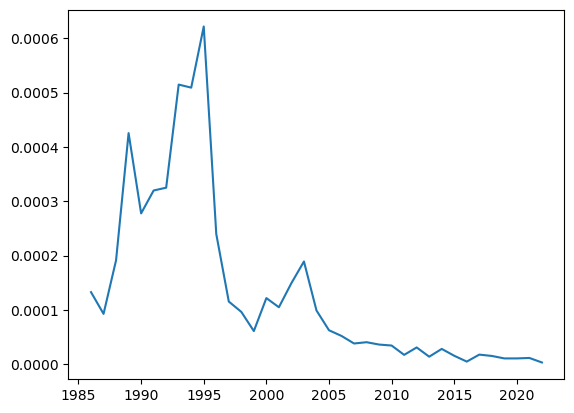

In [188]:
(pc_singleyear.set_index('year')['res_count']/single_year_pc_df).plot()

In [177]:
fp_singleyear = single_year_prox_df.loc['forest-pasture'].sort_index()

<Axes: xlabel='year'>

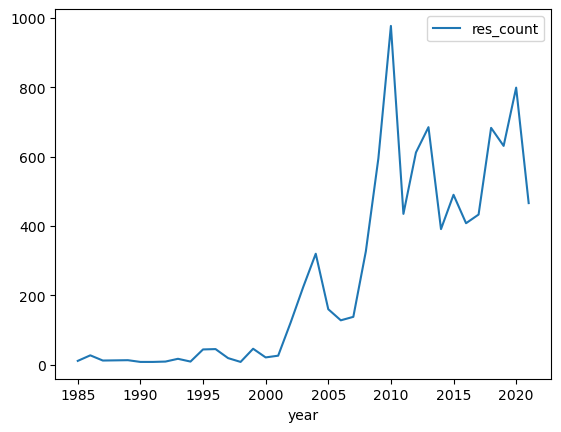

In [178]:
fp_singleyear.loc[:,'year'] = fp_singleyear.index + 2003
fp_singleyear.set_index('year').plot()

<Axes: >

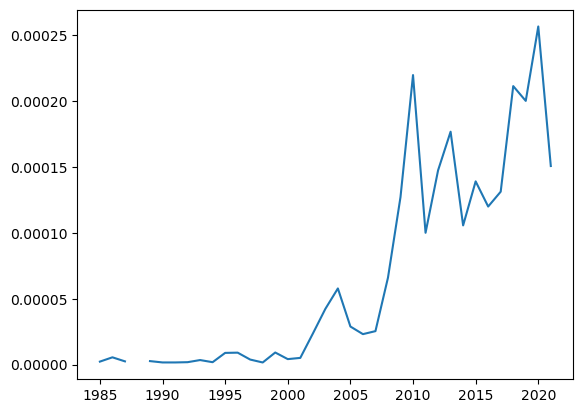

In [189]:
(fp_singleyear.set_index('year')['res_count']/single_year_fp_df).plot()